# How Does Ligo Point Back to a Source in the Sky?

Over the past couple years, the LIGO experiment has made the first measurements of 
gravitational waves. Along with the time structure of the signals, they also provide
some skymaps showing approximately where they think the source was. How might they 
do this?

In this notebook, I will show that you can do some pointing with timing information only.
We will start by setting up our environment.

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline


## Setting up the problem

The first thing we want to do is figure out where on Earth the LIGO sites are.
There are LIGO interferometers in Hanford, WA and in Livingston, LA.

The Hanford site is at (46.45,-119.41) and the Livingston site is at (30.56,-90.77).

There is a European interferometer called Virgo that would provide a third site.
According to Wikipedia, it is located at (43.63,10.50).

So, we first need to convert these into more useful coordinates. Regular spherical 
coordinates would be most useful.

In [34]:
def to_spherical(lat,lon):
    
    return np.pi/180 * np.array([90-lat,(360+lon)%360])

# Hanford, WA 
hanford_sph = to_spherical(46.45,-119.41)
# Livingston, LA 
livingston_sph = to_spherical(30.56,-90.77)
# Near Pisa, Tuscany
virgo_sph = to_spherical(43.64,10.50)

print('Hanford: ' +str(hanford_sph))
print('Livingston: ' +str(livingston_sph))
print('Virgo: ' +str(virgo_sph))


Hanford: [ 0.76009089  4.19908765]
Livingston: [ 1.03742371  4.69894995]
Virgo: [ 0.80913464  0.18325957]


The spherical coordinates here are a system where $\theta = 0$ corresponds to the direction
of up at the north pole, $(\theta,\phi) = (90^\circ,0^\circ)$ points up at the equator
on the prime meridian, and $(\theta,\phi) = (90^\circ,90^\circ)$ points up at at
the point (lat,lon)=(0,90), in the Indian Ocean south of Bangladesh.

This is a local coordinate system that rotates along with Earth, so if we want to 
point back to a specific place in the sky, we need to transform to a non-rotating
frame.

Now that things are in spherical coordinates, we'll actually keep transforming to
cartesian coordinates for our calculations.

In [41]:
def to_cartesian(th,ph):
    return np.array([
        np.sin(th)*np.cos(ph),
        np.sin(th)*np.sin(ph),
        np.cos(th)
        ]) 

hf = to_cartesian(hanford[0],hanford[1])
ls = to_cartesian(livingston[0],livingston[1])
vg = to_cartesian(virgo[0],virgo[1])

print('Hanford: ' +str(hf))
print('Livingston: ' +str(ls))
print('Virgo: ' +str(vg))

Hanford: [-0.33727687  0.59888243  0.72634988]
Livingston: [-0.01129104  0.8616207   0.50742713]
Virgo: [ 0.71167884  0.13193164  0.69000527]


Now we can ask ourselves what the maximum time separation allowed for different combinations of detectors is. Given vectors $\mathbf{v}_1$ and $\mathbf{v}_2$ for two sites, the distance between the sites is:

$ d =  R_\oplus |\mathbf{v}_1 - \mathbf{v}_2|$

where $R_\oplus$ is Earth's radius (assuming a spherical Earth). The maximal time separation between a gravitational wave signal traveling from one site to another is just $d/c$ and our vectors are unit vectors by construction, so we can write the time as:

$ \Delta t = \frac{R_\oplus}{c} \sqrt{2(1 - \mathbf{v}_1\cdot\mathbf{v}_2)}$


In [42]:
earthRadius = 6371e3 # m
speedOfLight = 3e8 # m/s

t_hl = earthRadius/speedOfLight * np.sqrt(2*(1-hf.dot(ls)))
t_hv = earthRadius/speedOfLight * np.sqrt(2*(1-hf.dot(vg)))
t_lv = earthRadius/speedOfLight * np.sqrt(2*(1-ls.dot(vg)))

print('Hanford/Livingston: %.2f msec'%(1e3*t_hl,))
print('Hanford/Virgo: %.2f msec'%(1e3*t_hv,))
print('Livingston/Virgo: %.2f msec'%(1e3*t_lv,))

Hanford/Livingston: 10.03 msec
Hanford/Virgo: 24.40 msec
Livingston/Virgo: 22.16 msec


So, we see that we get a maximum separation of 10 milliseconds between the two LIGO sites and 22-24 milliseconds
if we add Virgo.

## The Direction Likelihood

Now suppose we can measure the signal times at each site to some common uncertainty $\sigma$.
Then the uncertainty for the time separation $\Delta t = t_1 - t_2$ is just $\sigma\sqrt{2}$,
assuming no correlations between the time measurements. 

Now, the time is probably going to follow something like a Gaussian distribution, and if we 
combine multiple Gaussians, we just get another Gaussian, so the likelihood of measuring $\Delta t$ given some direction $(\theta,\phi)$ is:

$ L(\Delta t|\theta,\phi) = \frac{1}{\sqrt{8\pi \sigma^2}} \exp\left(-\frac{1}{8\sigma^2}(\Delta t - \frac{R_\oplus}{c}(\mathbf{v}_1 - \mathbf{v}_2)\cdot \mathbf{u}(\theta,\phi))^2\right)$

where $\mathbf{v}_i$ are the unit vectors of the two detectors and $\mathbf{u}(\theta,\phi)$ is the unit vector of the signal direction (opposite the source).

Using this, we can calculate the likelihood for LIGO (Hanford and Livingston) for a grid of $(\theta,\phi)$ points.

In [43]:
def Likelihood(time,uncertainty):
    uncertainty = np.sqrt(2) * uncertainty

    npts = 200
    phi = np.linspace(-np.pi,np.pi,npts)
    theta = np.linspace(0,np.pi,npts)
    grid_theta,grid_phi = np.meshgrid(theta,phi)

    likelihood = np.zeros([npts,npts])

    for i in range(npts):
        for j in range(npts):
            u = to_cartesian(grid_theta[i,j],grid_phi[i,j])
            hfCos = u.dot(hf)
            lCos = u.dot(ls)
            dx = earthRadius * (hfCos-lCos)
            dt = dx / speedOfLight
            #likelihood[i,j] = 1./ np.sqrt(2*np.pi*uncertainty**2)  \
            likelihood[i,j] = np.exp(-0.5*( (dt-time)/uncertainty) **2)
            #print(i,j,dt,t,likelihood[i,j])

    return grid_theta,grid_phi,likelihood

## Plotting the Results

Now that we can calculate the likelihood, we can plot the results.

The Basemap toolkit for Matplotlib provides some nice tools for making plots on 2D projections such as 
skymaps. We will use a Hammer projection for our plots here. In our projections, the top
is the direction of up at the north pole, the center is the direction of up at the equator on the prime meridian,
and the far left and right are both the same point on the equator in the Indian Ocean south of Bangladesh.

In [46]:
def make_plot(time,uncertainty):
    th,ph,ll = Likelihood(time,uncertainty)

    f = plt.figure(1,figsize=(10,5))
    bmap = Basemap(projection='hammer',lon_0=0)
    bmap.drawmeridians(np.arange(0,360,60),color='0.5')
    bmap.drawparallels(np.arange(-90,90,30),color='0.5')
    lats = 90 - 180./np.pi * th
    lons = ph * 180./np.pi
    x,y = bmap(lons,lats)

    bmap.pcolor(x,y,ll,cmap='gist_heat',vmin=0,vmax=1)
    cb = bmap.colorbar(location='right')
    cb.set_label('Likelihood',size=18)
    plt.title(r'Hammer Projection, $\Delta t = $%.2e $\pm$ %0.2e'%(time,uncertainty),size=18)

    cb.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
    cb.ax.tick_params(labelsize=16)
    plt.show()

### 10 ms separation, 1 ms uncertainty

This is right around the maximum separation. We see a single blob here where the likelihood is high.

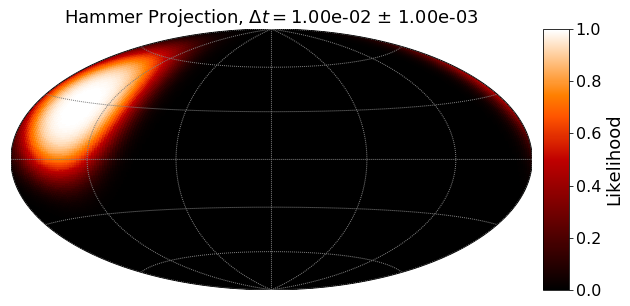

In [45]:
make_plot(0.01,0.001)

### 8 ms separation, 1 ms uncertainty

At this point, the blob is becoming a ring of high probability.

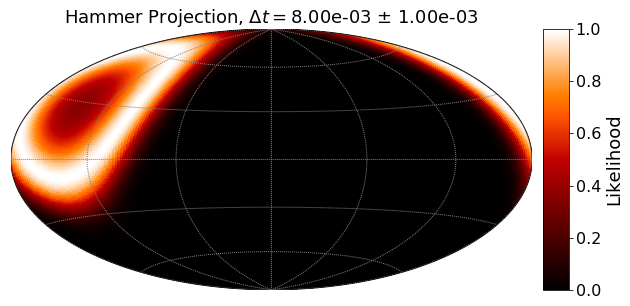

In [23]:
make_plot(0.008,0.001)

### 4 ms separation 1 ms uncertainty

There is clearly a ring here.

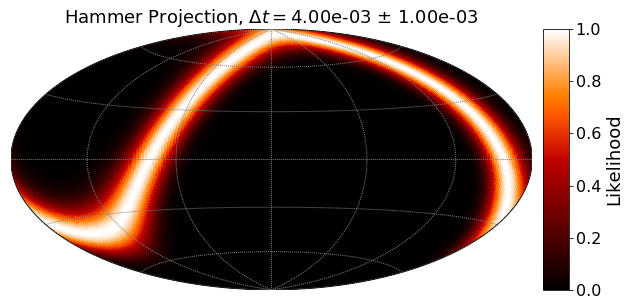

In [24]:
make_plot(0.004,0.001)

### No separation, 1 ms uncertainty

When there is no separation, the resulting ring should be a great circle. As we then go to negative separation,
we are just going to mirror the positive separation curves.

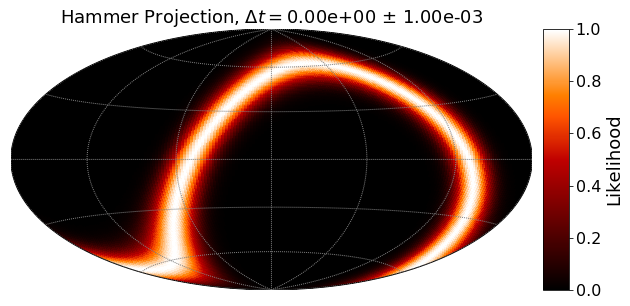

In [25]:
make_plot(0.0,0.001)

### No separation, 5 ms uncertainty

If the uncertainty gets too much bigger, the high probability region starts to smear out over the entire sky.

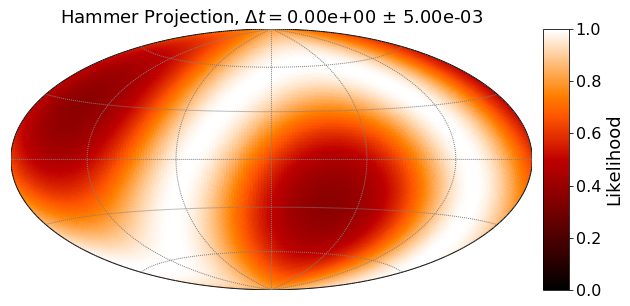

In [31]:
make_plot(0.0,0.005)

### No separation, 100 $\mu$s uncertainty

If the separation gets smaller, the ring gets much narrower. 100 $\mu$s is about the lowest we can go before we should increase the number of data points.

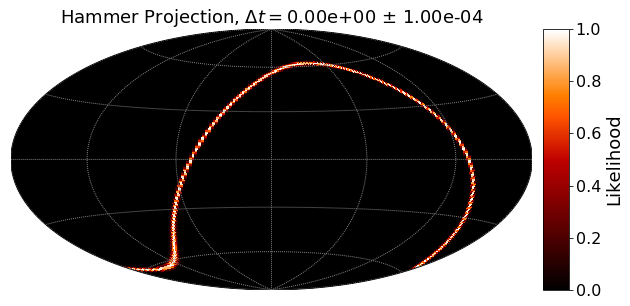

In [32]:
make_plot(0.0,0.0001)

### 10 ms separation, 100 $\mu$s uncertainty

At maximal separation, the blob just starts to get smaller, and it looks like we're starting to see some ring structure since this isn't exactly at maximal separation.

In [ ]:
make_plot(0.01,0.0001)

### High separation, 1 ms uncertainty

As the measured time difference gets bigger than the maximal separation, we see that
the maximum likelihood starts dropping, and as we get to several $\sigma$ longer than
maximal separation, the likelihood is basically zero everywhere.

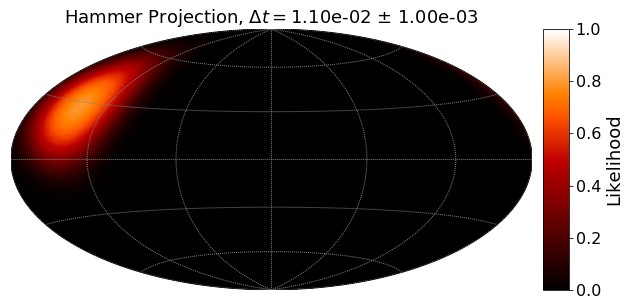

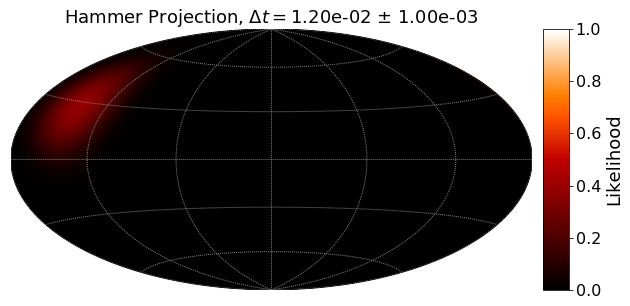

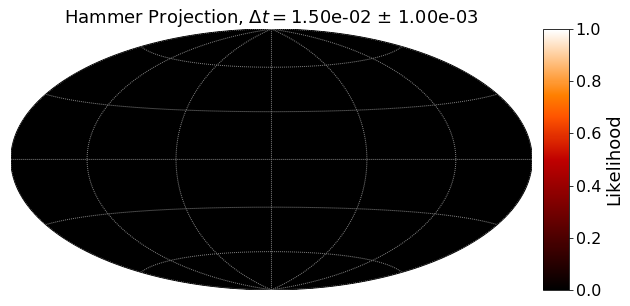

In [51]:
make_plot(0.011,0.001)
make_plot(0.012,0.001)
make_plot(0.015,0.001)

## Why Have 3 Detectors?

I don't have any code for this right now, but 3 detectors will break the degeneracy between the different points on the rings and will give us a blob-like likelihood peak for all angles.